In [57]:
import sys
sys.path.append('..')
from Map import Map

from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime, timedelta
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc
from scipy.ndimage import gaussian_filter

## Model Reflectivity

In [58]:
%%capture

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 35
LEFT_LON = -90
RIGHT_LON = -75

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20220630/hrrr_sfc.t00z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200503/rap_21z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20200429/gfs_0p25_18z'

base_url = hrrr

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values

# Capture model variable we want to plot
data = ds.refcclm

In [59]:
def make_figure():
    new_map = Map('tampa_area')
    new_map.add_counties()
    fig, ax = new_map.make_map()
    return fig, ax

## Time Conversion from UTC to Eastern Time

In [65]:
def roundTime(dt=None, roundTo=60):
    """Round a datetime object to any time lapse in seconds
    dt : datetime.datetime object, default now.
    roundTo : Closest number of seconds to round to, default 1 minute.
    Author: Thierry Husson 2012 - Use it as you want but don't blame me.
    """
    if dt == None : dt = datetime.now()
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
    return dt + timedelta(0,rounding-seconds,-dt.microsecond)

def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    eastern = roundTime(eastern)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

datetime.datetime(2022, 6, 29, 23, 25)

## Model Time Series
Function to plot model data and manage text/contours so they're removed before the next timestep is plotted

In [61]:
def plot_model_data(time_step):
    refl = data.isel(time=time_step)
    local_time = convert_datetime_from_nomads_to_local(str(refl.time.values).split('.')[0])
    refl = refl.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array 
    return refl, local_time

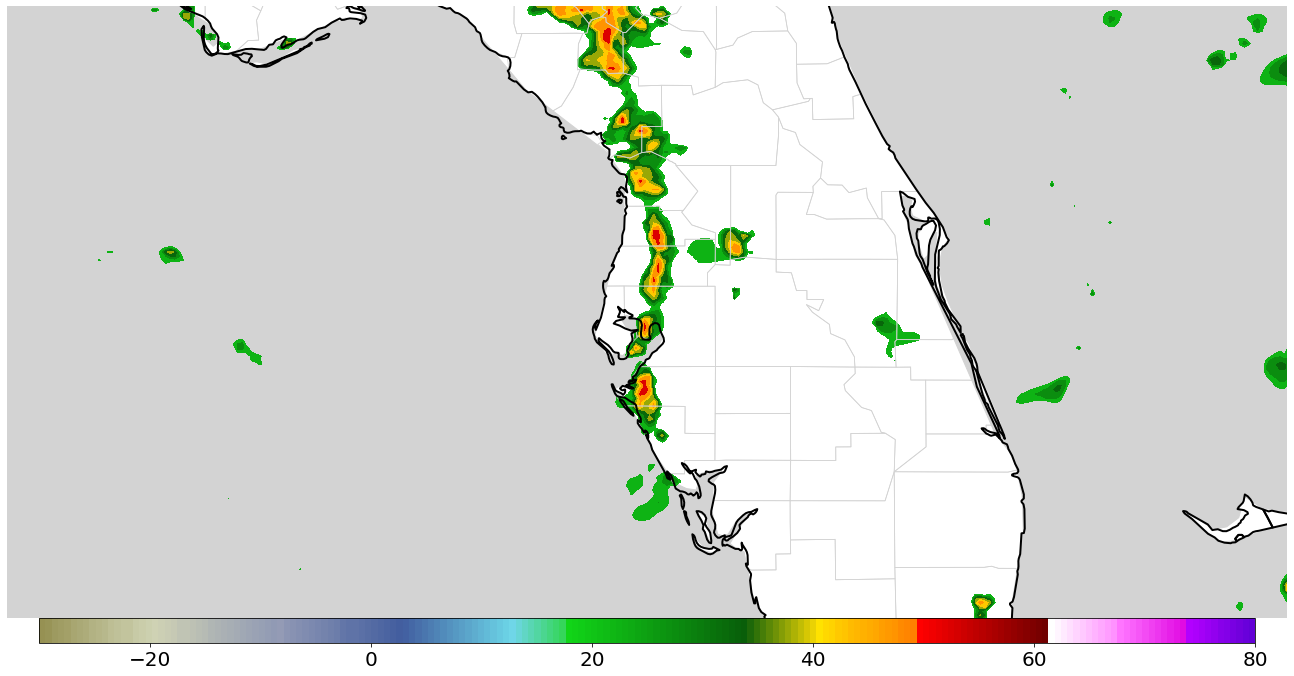

In [62]:
fig, ax = make_figure()

norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)

# Plot Colorbar
xy = range(80)
sc = plt.scatter(xy, xy, c=xy, s=35, cmap=cmap, norm=Normalize(-30, 80))
cbar = plt.colorbar(sc, orientation='horizontal', pad=0, aspect=50, shrink=0.95)
cbar.ax.tick_params(labelsize=20)

# Initialize plot
refl, local_time = plot_model_data(0)
contour_fill = ax.contourf(lons, lats, refl, np.arange(20, 80, 5),
                   cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())

## Animation function

In [63]:
def animate(frame, start_hour):
    global contour_fill
    frame += start_hour
    refl, local_time = plot_model_data(frame)
    for c in contour_fill.collections:
        c.remove()
    for txt in ax.texts:
        txt.set_visible(False)
    contour_fill = ax.contourf(lons, lats, refl, np.arange(20, 80, 5),
                   cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())
    ax.text(0.02, 0.95, s=f'Model Simulated Radar\n{local_time}',
            fontsize=36, fontweight='bold', fontname='Arial',
            color='white', 
            bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
            transform=ax.transAxes, zorder=10, va='top')
    return contour_fill

## Display JS Animator within Jupyter Lab
Execute the code that builds the animation

In [64]:
plt.rcParams['animation.html'] = 'jshtml'

START_HOUR = 18
END_HOUR = 29

anim = FuncAnimation(fig, animate,
                     frames=END_HOUR - START_HOUR, 
                     interval=300,
                     fargs=(START_HOUR, ))
anim

## Write MP4 and GIF

In [66]:
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'
anim.save(f'{graphics_dir}/reflectivity_hrrr.gif', writer='pillow', fps=1.5)

In [ ]:
if __name__ == '__main__':
    